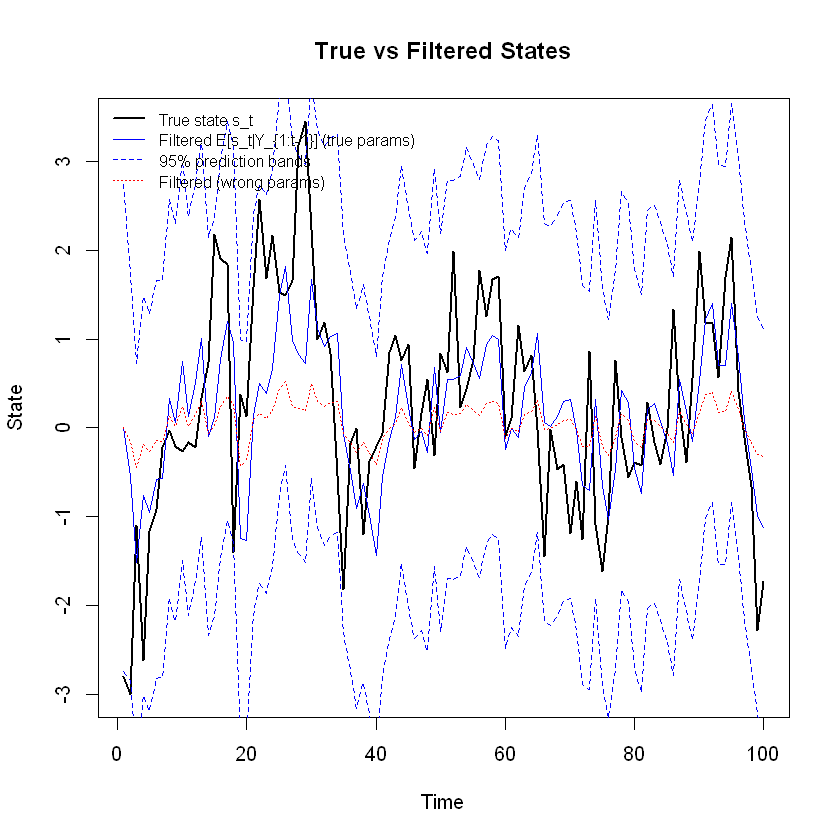

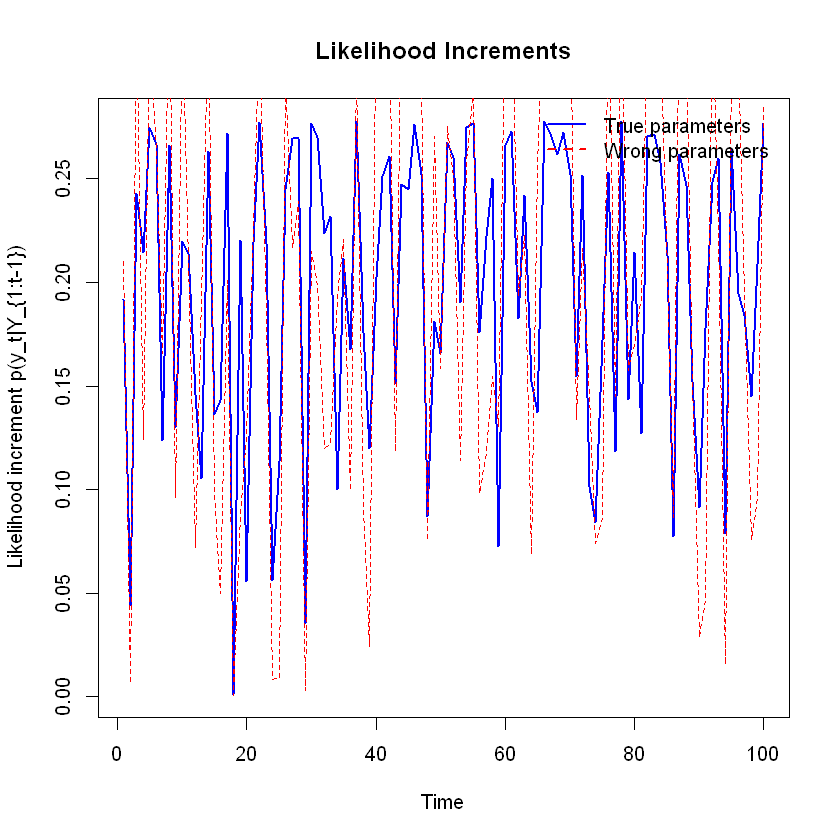

In [ ]:
# =========================
# EI139 PS2 – Problem 2 code (R) - REVISED
# =========================
set.seed(2025)

# 修改后的模拟函数，正确处理平稳初始化和相关误差
simulate_ssm <- function(T=100, lam=1.0, phi=0.8, rho=0.0, seed=NULL){
  if(!is.null(seed)) set.seed(seed)
  
  # 生成相关的(u_t, ε_t)序列
  Sigma <- matrix(c(1, rho, rho, 1), 2, 2)
  eps_u <- MASS::mvrnorm(T, mu=c(0,0), Sigma=Sigma)
  eps <- eps_u[,1]
  u <- eps_u[,2]
  
  # 从平稳分布初始化s_1
  s <- numeric(T)
  s[1] <- rnorm(1, 0, sqrt(1/(1-phi^2)))
  
  # 生成状态序列
  for(t in 2:T){
    s[t] <- phi * s[t-1] + eps[t]
  }
  
  y <- lam * s + u
  list(s=s, y=y, eps=eps, u=u)
}

# 修正的卡尔曼滤波，明确区分预测和更新步骤
kalman_filter <- function(y, lam, phi, rho=0.0){
  Tn <- length(y)
  
  # 初始化数组
  m_pred <- P_pred <- m_filt <- P_filt <- loglik_t <- numeric(Tn)
  
  # 从平稳分布初始化
  m_prev <- 0.0
  P_prev <- 1/(1-phi^2)  # 稳态方差，而非扩散先验
  
  for(t in 1:Tn){
    # 预测步骤 (t|t-1)
    m_t_pred <- phi * m_prev
    P_t_pred <- phi^2 * P_prev + 1.0  # Q = Var(ε_t) = 1
    
    # 计算预测误差和创新方差
    v_t <- y[t] - lam * m_t_pred
    F_t <- lam^2 * P_t_pred + 1.0 + 2 * lam * rho  # 注意: 当rho≠0时需要调整
    
    # 卡尔曼增益
    K_t <- (lam * P_t_pred + rho) / F_t
    
    # 更新步骤 (t|t)
    m_t_filt <- m_t_pred + K_t * v_t
    P_t_filt <- P_t_pred - K_t * (lam * P_t_pred + rho)
    
    # 存储结果
    m_pred[t] <- m_t_pred    # E[s_t|Y_{1:t-1}]
    P_pred[t] <- P_t_pred    # V[s_t|Y_{1:t-1}]
    m_filt[t] <- m_t_filt    # E[s_t|Y_{1:t}]
    P_filt[t] <- P_t_filt    # V[s_t|Y_{1:t}]
    
    # 对数似然增量
    loglik_t[t] <- -0.5*(log(2*pi) + log(F_t) + v_t^2/F_t)
    
    # 为下一期准备
    m_prev <- m_t_filt
    P_prev <- P_t_filt
  }
  
  list(m_pred=m_pred, P_pred=P_pred, 
       m_filt=m_filt, P_filt=P_filt, 
       loglik_t=loglik_t)
}

# 对数似然函数包装器
loglik_ssm <- function(y, lam, phi, rho=0.0){
  sum(kalman_filter(y, lam, phi, rho)$loglik_t)
}

# =========================
# (d)-(e) 部分：模拟数据和基础分析
# =========================

# 生成数据（使用独立误差，rho=0）
lam_true <- 0.9
phi_true <- 0.7
T_val <- 100

sim <- simulate_ssm(T=T_val, lam=lam_true, phi=phi_true, rho=0.0, seed=42)
y <- sim$y
s <- sim$s

# 使用真实参数运行卡尔曼滤波
out_true <- kalman_filter(y, lam=lam_true, phi=phi_true, rho=0.0)

# 使用错误参数运行卡尔曼滤波（用于比较）
out_wrong <- kalman_filter(y, lam=0.5, phi=0.3, rho=0.0)

# 绘图1：真实状态、滤波状态和置信带（单独保存为 PNG）
tgrid <- 1:T_val
se_pred <- sqrt(out_true$P_pred)  # 预测标准差

# 保存第一个图像：True vs Filtered States
# png("PS_plot_states.png", width=800, height=600)
plot(tgrid, s, type="l", lwd=2, col=1,
     ylab="State", xlab="Time",
     main="True vs Filtered States",
     ylim=range(s, out_true$m_pred, out_wrong$m_pred))
lines(tgrid, out_true$m_pred, col="blue", lwd=1.5)
lines(tgrid, out_true$m_pred + 1.96*se_pred, col="blue", lty=2, lwd=1)
lines(tgrid, out_true$m_pred - 1.96*se_pred, col="blue", lty=2, lwd=1)
lines(tgrid, out_wrong$m_pred, col="red", lwd=1.5, lty=3)
legend("topleft", 
       c("True state s_t", 
         "Filtered E[s_t|Y_{1:t-1}] (true params)",
         "95% prediction bands",
         "Filtered (wrong params)"),
       col=c(1, "blue", "blue", "red"),
       lty=c(1,1,2,3), lwd=c(2,1.5,1,1.5),
       bty="n", cex=0.8)
# dev.off()
# 如果在 notebook 中，尝试显示图像（需要 knitr）
# if(requireNamespace("knitr", quietly=TRUE)) print(knitr::include_graphics("PS_plot_states.png"))

# 保存第二个图像：似然增量序列（非累积）
# png("PS_plot_likelihoods.png", width=800, height=600)
plot(tgrid, exp(out_true$loglik_t), type="l", lwd=2, col="blue",
     ylab="Likelihood increment p(y_t|Y_{1:t-1})",
     xlab="Time", main="Likelihood Increments")
lines(tgrid, exp(out_wrong$loglik_t), col="red", lwd=1.5, lty=2)
legend("topright", c("True parameters", "Wrong parameters"),
       col=c("blue", "red"), lty=1:2, lwd=2:1.5, bty="n")
# dev.off()
# if(requireNamespace("knitr", quietly=TRUE)) print(knitr::include_graphics("PS_plot_likelihoods.png"))


Grid search MLE: φ_hat = 0.6601 (true φ = 0.70)


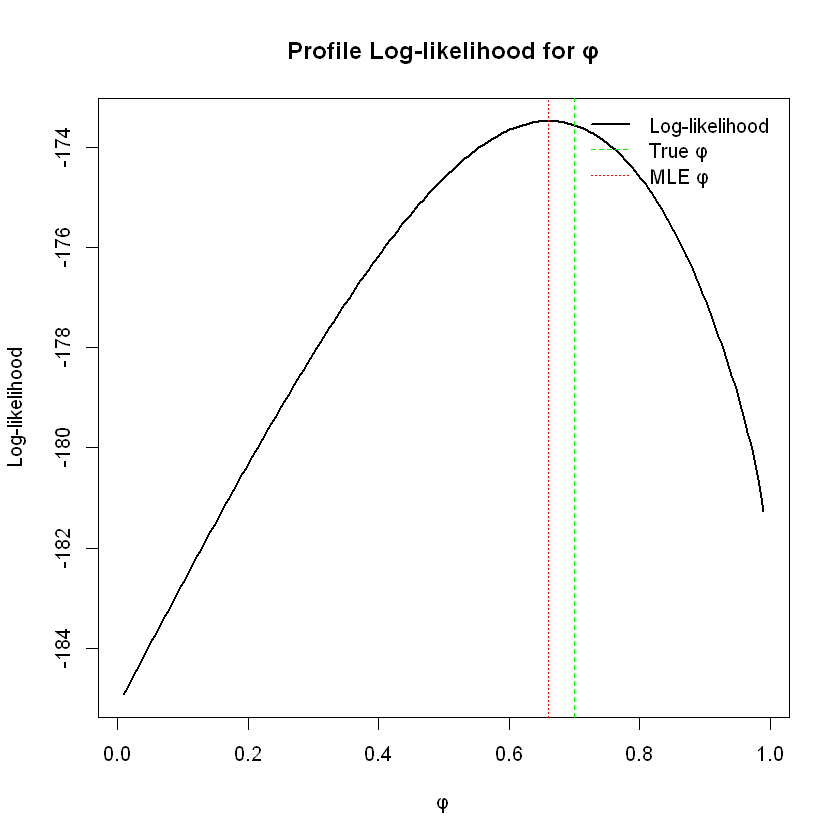

In [2]:

# =========================
# (f) 部分：对φ进行网格搜索
# =========================

# 创建φ的网格（排除边界）
phi_grid <- seq(0.01, 0.99, length.out=200)
ll_grid <- sapply(phi_grid, function(p) loglik_ssm(y, lam=lam_true, phi=p))

# 找到最大似然估计
phi_hat_grid <- phi_grid[which.max(ll_grid)]
cat(sprintf("Grid search MLE: φ_hat = %.4f (true φ = %.2f)\n", 
            phi_hat_grid, phi_true))

# 绘图：对数似然函数
plot(phi_grid, ll_grid, type="l", lwd=2,
     xlab="φ", ylab="Log-likelihood",
     main="Profile Log-likelihood for φ")
abline(v=phi_true, col="green", lty=2, lwd=1.5)
abline(v=phi_hat_grid, col="red", lty=3, lwd=1.5)
legend("topright", c("Log-likelihood", "True φ", "MLE φ"),
       col=c(1, "green", "red"), lty=c(1,2,3), lwd=c(2,1.5,1.5), bty="n")


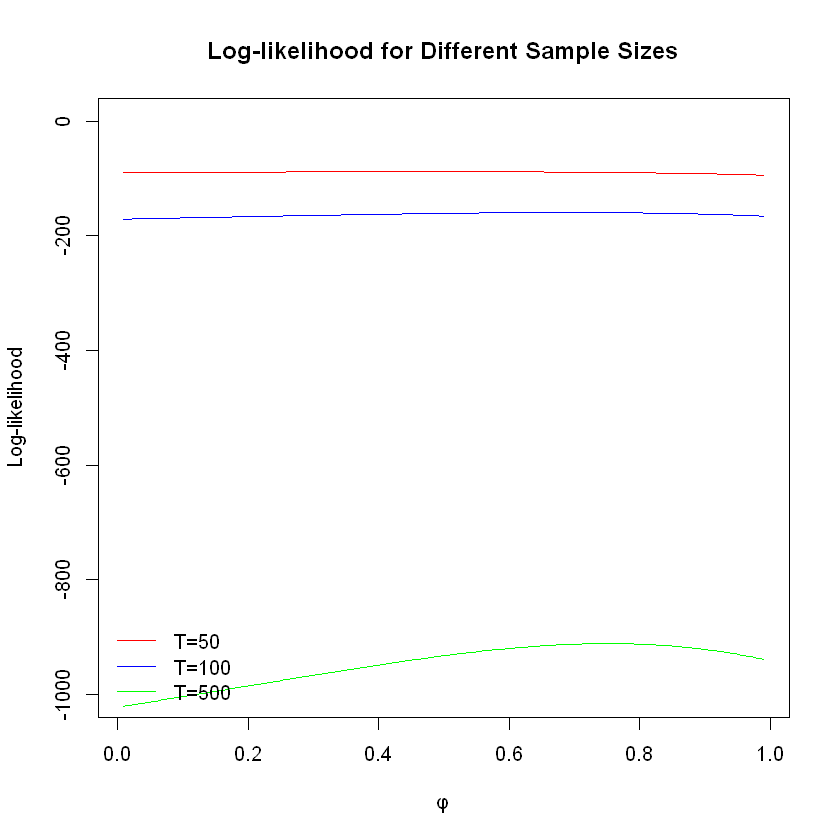

In [3]:

# =========================
# (g) 部分：不同样本量
# =========================

sample_sizes <- c(50, 100, 500)
colors <- c("red", "blue", "green")

# 准备绘图
plot(phi_grid, ll_grid, type="n",
     xlab="φ", ylab="Log-likelihood",
     main="Log-likelihood for Different Sample Sizes",
     ylim=c(-1000, 0))  # 调整y轴范围

# 对每个样本量计算对数似然
for (i in 1:length(sample_sizes)) {
  T_i <- sample_sizes[i]
  sim_i <- simulate_ssm(T=T_i, lam=lam_true, phi=phi_true, seed=100+T_i)
  ll_i <- sapply(phi_grid, function(p) loglik_ssm(sim_i$y, lam=lam_true, phi=p))
  lines(phi_grid, ll_i, col=colors[i], lwd=1.5)
}

legend("bottomleft", legend=paste0("T=", sample_sizes),
       col=colors, lty=1, lwd=1.5, bty="n")


In [4]:

# =========================
# (h) 部分：数值优化
# =========================

# 负对数似然函数（用于最小化）
neg_loglik <- function(phi) {
  if(phi <= 0 || phi >= 1) return(Inf)
  -loglik_ssm(y, lam=lam_true, phi=phi)
}

# 使用optimize进行一维优化
opt_result <- optimize(neg_loglik, interval=c(0.01, 0.99))
phi_hat_opt <- opt_result$minimum

cat(sprintf("Numerical optimization:\n"))
cat(sprintf("  φ_hat (optim) = %.6f\n", phi_hat_opt))
cat(sprintf("  φ_hat (grid)  = %.6f\n", phi_hat_grid))
cat(sprintf("  Difference    = %.6f\n", abs(phi_hat_opt - phi_hat_grid)))
cat(sprintf("  Log-lik at opt = %.4f\n", -opt_result$objective))


Numerical optimization:
  φ_hat (optim) = 0.660893
  φ_hat (grid)  = 0.660050
  Difference    = 0.000843


  Log-lik at opt = -173.4745



Sample autocovariances (with correlation):


  γ[0] = 2.7762
  γ[1] = 1.0394
  γ[2] = 0.6297
  γ[3] = 0.8979

Log-likelihood comparison:
  With correct rho=0.50: -185.6992
  Assuming rho=0:        -185.4046
  Difference:            -0.2946


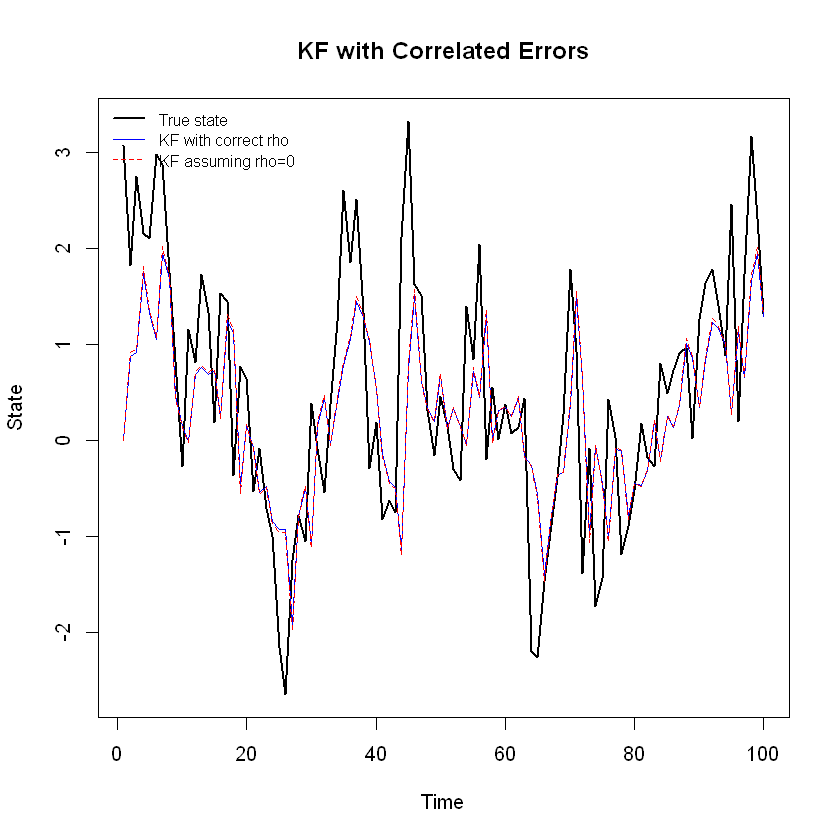

In [5]:

# =========================
# (i)-(j) 部分：相关误差情况
# =========================

# 生成相关误差的数据
rho_val <- 0.5
sim_corr <- simulate_ssm(T=100, lam=lam_true, phi=phi_true, rho=rho_val, seed=123)

# 计算样本自协方差（用于验证理论推导）
acf_y <- acf(sim_corr$y, lag.max=10, plot=FALSE)
cat("\nSample autocovariances (with correlation):\n")
for(k in 0:3) {
  cat(sprintf("  γ[%d] = %.4f\n", k, acf_y$acf[k+1]*var(sim_corr$y)))
}

# 使用相关卡尔曼滤波
kf_corr <- kalman_filter(sim_corr$y, lam=lam_true, phi=phi_true, rho=rho_val)

# 使用独立假设的错误滤波（比较）
kf_wrong <- kalman_filter(sim_corr$y, lam=lam_true, phi=phi_true, rho=0.0)

# 绘图比较相关与独立假设
plot(tgrid, sim_corr$s, type="l", lwd=2, col=1,
     ylab="State", xlab="Time",
     main="KF with Correlated Errors",
     ylim=range(sim_corr$s, kf_corr$m_pred, kf_wrong$m_pred))
lines(tgrid, kf_corr$m_pred, col="blue", lwd=1.5)
lines(tgrid, kf_wrong$m_pred, col="red", lwd=1.5, lty=2)
legend("topleft", 
       c("True state", "KF with correct rho", "KF assuming rho=0"),
       col=c(1, "blue", "red"), lty=c(1,1,2), lwd=c(2,1.5,1.5),
       bty="n", cex=0.8)

# 比较似然值
ll_corr <- sum(kf_corr$loglik_t)
ll_wrong <- sum(kf_wrong$loglik_t)
cat(sprintf("\nLog-likelihood comparison:\n"))
cat(sprintf("  With correct rho=%.2f: %.4f\n", rho_val, ll_corr))
cat(sprintf("  Assuming rho=0:        %.4f\n", ll_wrong))
cat(sprintf("  Difference:            %.4f\n", ll_corr - ll_wrong))

par(mfrow=c(1,1))  # 重置图形参数

Part (d)-(e): Basic Simulation and Kalman Filter


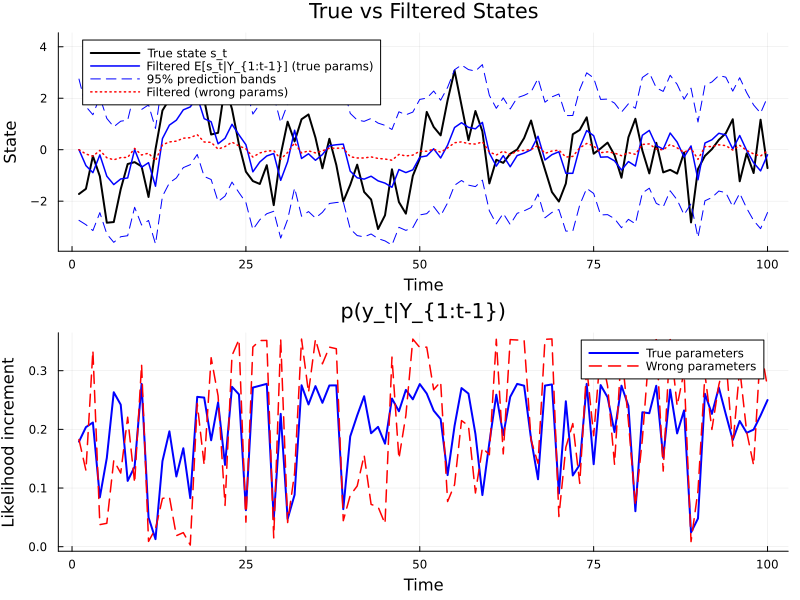

In [ ]:
# =========================
# EI139 PS2 - Problem 2: State-Space Model (Revised Julia Code)
# =========================

using Random, Distributions, LinearAlgebra, Statistics, Printf
using Plots, Optim

# 设置随机种子
Random.seed!(2025)

# =========================
# 辅助函数
# =========================

"""
模拟状态空间模型数据

参数:
- T: 样本量
- λ: 测量方程系数
- φ: 状态转移系数
- ρ: u_t和ε_t之间的相关系数 (默认0)
- seed: 随机种子

返回:
- s: 状态序列
- y: 观测序列
- ε: 状态创新序列
- u: 测量误差序列
"""
function simulate_ssm(T::Int=100, λ::Float64=1.0, φ::Float64=0.8, ρ::Float64=0.0; seed::Int=2025)
    Random.seed!(seed)
    
    # 生成相关的(u_t, ε_t)序列
    Σ = [1.0 ρ; ρ 1.0]
    dist = MvNormal(Σ)
    ε_u = rand(dist, T)
    ε = ε_u[1, :]  # 状态创新
    u = ε_u[2, :]  # 测量误差
    
    # 从平稳分布初始化s_1
    s = zeros(T)
    s[1] = rand(Normal(0.0, sqrt(1/(1-φ^2))))
    
    # 生成状态序列
    for t in 2:T
        s[t] = φ * s[t-1] + ε[t]
    end
    
    # 生成观测序列
    y = λ .* s .+ u
    
    return s, y, ε, u
end

"""
卡尔曼滤波算法

参数:
- y: 观测序列
- λ: 测量方程系数
- φ: 状态转移系数
- ρ: u_t和ε_t之间的相关系数 (默认0)

返回:
- m_pred: E[s_t|Y_{1:t-1}] (预测状态均值)
- P_pred: V[s_t|Y_{1:t-1}] (预测状态方差)
- m_filt: E[s_t|Y_{1:t}] (滤波状态均值)
- P_filt: V[s_t|Y_{1:t}] (滤波状态方差)
- loglik_t: 对数似然增量 log p(y_t|Y_{1:t-1})
"""
function kalman_filter(y::Vector{Float64}, λ::Float64, φ::Float64; ρ::Float64=0.0)
    T = length(y)
    
    # 初始化数组
    m_pred = zeros(T)  # E[s_t|Y_{1:t-1}]
    P_pred = zeros(T)  # V[s_t|Y_{1:t-1}]
    m_filt = zeros(T)  # E[s_t|Y_{1:t}]
    P_filt = zeros(T)  # V[s_t|Y_{1:t}]
    loglik_t = zeros(T)  # log p(y_t|Y_{1:t-1})
    
    # 从平稳分布初始化
    m_prev = 0.0
    P_prev = 1/(1-φ^2)  # 稳态方差
    
    for t in 1:T
        # 1. 预测步骤 (t|t-1)
        m_t_pred = φ * m_prev
        P_t_pred = φ^2 * P_prev + 1.0  # Q = Var(ε_t) = 1
        
        # 2. 计算预测误差和创新方差
        v_t = y[t] - λ * m_t_pred  # 预测误差
        F_t = λ^2 * P_t_pred + 1.0 + 2 * λ * ρ  # 创新方差
        
        # 3. 卡尔曼增益
        K_t = (λ * P_t_pred + ρ) / F_t
        
        # 4. 更新步骤 (t|t)
        m_t_filt = m_t_pred + K_t * v_t
        P_t_filt = P_t_pred - K_t * (λ * P_t_pred + ρ)
        
        # 5. 对数似然增量
        loglik_t[t] = -0.5 * (log(2π) + log(F_t) + v_t^2 / F_t)
        
        # 6. 存储结果
        m_pred[t] = m_t_pred
        P_pred[t] = P_t_pred
        m_filt[t] = m_t_filt
        P_filt[t] = P_t_filt
        
        # 7. 为下一期准备
        m_prev = m_t_filt
        P_prev = P_t_filt
    end
    
    return (m_pred=m_pred, P_pred=P_pred, 
            m_filt=m_filt, P_filt=P_filt, 
            loglik_t=loglik_t)
end

"""
计算状态空间模型的对数似然值

参数:
- y: 观测序列
- λ: 测量方程系数
- φ: 状态转移系数
- ρ: u_t和ε_t之间的相关系数 (默认0)

返回:
- 对数似然值
"""
function loglik_ssm(y::Vector{Float64}, λ::Float64, φ::Float64; ρ::Float64=0.0)
    kf = kalman_filter(y, λ, φ; ρ=ρ)
    return sum(kf.loglik_t)
end

# =========================
# (d)-(e) 部分: 模拟数据和基础分析
# =========================

println("="^60)
println("Part (d)-(e): Basic Simulation and Kalman Filter")
println("="^60)

# 真实参数
λ_true = 0.9
φ_true = 0.7
T_val = 100

# 生成数据 (ρ=0，独立误差)
s, y, ε, u = simulate_ssm(T_val, λ_true, φ_true, 0.0, seed=42)

# 使用真实参数运行卡尔曼滤波
kf_true = kalman_filter(y, λ_true, φ_true)

# 使用错误参数运行卡尔曼滤波 (用于比较)
λ_wrong = 0.5
φ_wrong = 0.3
kf_wrong = kalman_filter(y, λ_wrong, φ_wrong)

# 绘图1: 真实状态、滤波状态和置信带
tgrid = 1:T_val
se_pred = sqrt.(kf_true.P_pred)  # 预测标准差

p1 = plot(tgrid, s, 
          linewidth=2, color=:black, label="True state s_t",
          xlabel="Time", ylabel="State",
          title="True vs Filtered States",
          legend=:topleft)

plot!(tgrid, kf_true.m_pred, 
      linewidth=1.5, color=:blue, label="Filtered E[s_t|Y_{1:t-1}] (true params)")

# 添加95%预测区间
plot!(tgrid, kf_true.m_pred .+ 1.96 .* se_pred, 
      linewidth=1, linestyle=:dash, color=:blue, label="95% prediction bands")

plot!(tgrid, kf_true.m_pred .- 1.96 .* se_pred, 
      linewidth=1, linestyle=:dash, color=:blue, label="")

# 错误参数的结果
plot!(tgrid, kf_wrong.m_pred, 
      linewidth=1.5, linestyle=:dot, color=:red, label="Filtered (wrong params)")

# 绘图2: 似然增量序列
p2 = plot(tgrid, exp.(kf_true.loglik_t), 
          linewidth=2, color=:blue, label="True parameters",
          xlabel="Time", ylabel="Likelihood increment",
          title="p(y_t|Y_{1:t-1})",
          legend=:topright)

plot!(tgrid, exp.(kf_wrong.loglik_t), 
      linewidth=1.5, linestyle=:dash, color=:red, label="Wrong parameters")

# 显示绘图
plot(p1, p2, layout=(2,1), size=(800, 600))


In [ ]:

# 计算累积对数似然
cum_loglik_true = cumsum(kf_true.loglik_t)
cum_loglik_wrong = cumsum(kf_wrong.loglik_t)

println("Cumulative log-likelihood at end:")
println("  True parameters (λ=$(λ_true), φ=$(φ_true)): $(cum_loglik_true[end])")
println("  Wrong parameters (λ=$(λ_wrong), φ=$(φ_wrong)): $(cum_loglik_wrong[end])")


Cumulative log-likelihood at end:
  True parameters (λ=0.9, φ=0.7): -172.0512623162406
  Wrong parameters (λ=0.5, φ=0.3): -187.30482180796733



Part (f): Grid Search for φ
Grid search MLE: φ_hat = 0.6748 (true φ = 0.70)


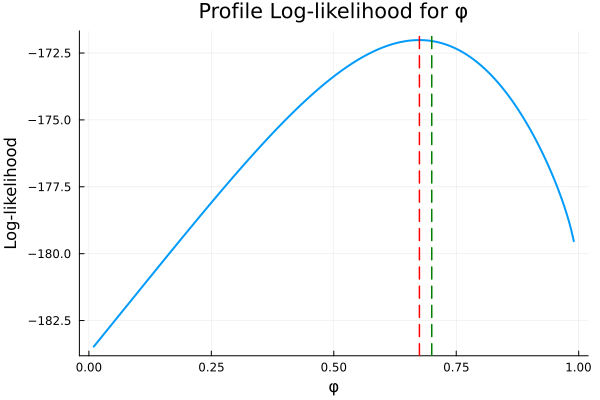

In [ ]:

# =========================
# (f) 部分: 对φ进行网格搜索
# =========================

println("\n" * "="^60)
println("Part (f): Grid Search for φ")
println("="^60)

# 创建φ的网格 (排除边界)
φ_grid = range(0.01, 0.99, length=200)
ll_grid = [loglik_ssm(y, λ_true, φ) for φ in φ_grid]

# 找到最大似然估计
φ_hat_grid = φ_grid[argmax(ll_grid)]
@printf "Grid search MLE: φ_hat = %.4f (true φ = %.2f)\n" φ_hat_grid φ_true

# 绘图: 对数似然函数
p3 = plot(φ_grid, ll_grid, 
          linewidth=2, 
          xlabel="φ", ylabel="Log-likelihood",
          title="Profile Log-likelihood for φ",
          legend=false)

vline!([φ_true], linewidth=1.5, linestyle=:dash, color=:green, label="True φ")
vline!([φ_hat_grid], linewidth=1.5, linestyle=:dash, color=:red, label="MLE φ")

# 添加图例
plot!([], [], linewidth=2, color=:black, label="Log-likelihood")
plot!([], [], linewidth=1.5, linestyle=:dash, color=:green, label="True φ")
plot!([], [], linewidth=1.5, linestyle=:dash, color=:red, label="MLE φ")

display(p3)



Part (g): Different Sample Sizes


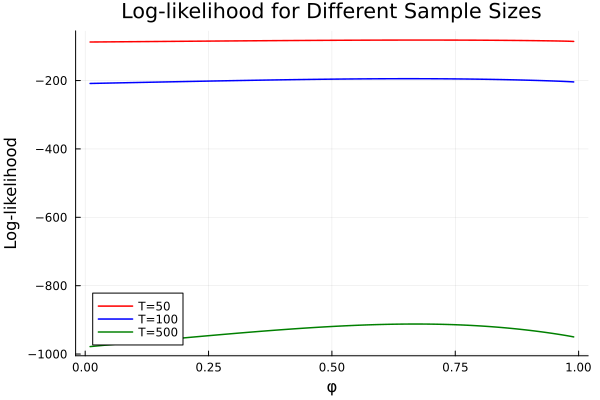

In [ ]:

# =========================
# (g) 部分: 不同样本量
# =========================

println("\n" * "="^60)
println("Part (g): Different Sample Sizes")
println("="^60)

sample_sizes = [50, 100, 500]
colors = [:red, :blue, :green]

# 准备绘图
p4 = plot(xlabel="φ", ylabel="Log-likelihood",
          title="Log-likelihood for Different Sample Sizes",
          legend=:bottomleft)

# 对每个样本量计算对数似然
for (i, T_i) in enumerate(sample_sizes)
    # 生成新数据
    s_i, y_i, _, _ = simulate_ssm(T_i, λ_true, φ_true, seed=100+T_i)
    
    # 计算对数似然
    ll_i = [loglik_ssm(y_i, λ_true, φ) for φ in φ_grid]
    
    # 绘图
    plot!(φ_grid, ll_i, 
          linewidth=1.5, color=colors[i], label="T=$(T_i)")
end

display(p4)


In [ ]:

# =========================
# (h) 部分: 数值优化
# =========================

println("\n" * "="^60)
println("Part (h): Numerical Optimization")
println("="^60)

# 负对数似然函数 (用于最小化)
function neg_loglik(φ)
    if φ <= 0.0 || φ >= 1.0
        return Inf
    end
    return -loglik_ssm(y, λ_true, φ)
end

# 使用optimize进行一维优化
opt_result = optimize(neg_loglik, 0.01, 0.99)
φ_hat_opt = opt_result.minimizer

@printf "Numerical optimization:\n"
@printf "  φ_hat (optim) = %.6f\n" φ_hat_opt
@printf "  φ_hat (grid)  = %.6f\n" φ_hat_grid
@printf "  Difference    = %.6f\n" abs(φ_hat_opt - φ_hat_grid)
@printf "  Log-lik at opt = %.4f\n" -opt_result.minimum



Part (h): Numerical Optimization
Numerical optimization:
  φ_hat (optim) = 0.674622
  φ_hat (grid)  = 0.674824
  Difference    = 0.000202
  Log-lik at opt = -172.0160



Part (i)-(j): Correlated Errors

Sample autocovariances (with correlation ρ=0.5):
  γ[0] = 2.9035
  γ[1] = 0.5245
  γ[2] = 0.0837
  γ[3] = -0.0999

Theoretical autocovariances:
  γ[0] = 3.4882
  γ[1] = 1.4268
  γ[2] = 0.7782
  γ[3] = 0.5448


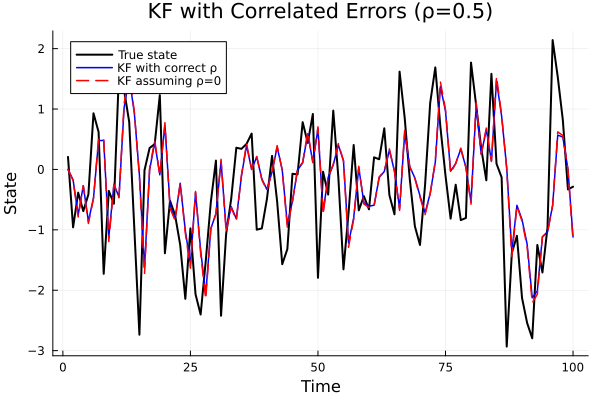


Log-likelihood comparison:
  With correct ρ=0.50: -197.0689
  Assuming ρ=0:        -201.4353
  Difference:          4.3664

ARMA(1,1) Representation


LoadError: ArgumentError: Package StatsBase not found in current path.
- Run `import Pkg; Pkg.add("StatsBase")` to install the StatsBase package.

In [ ]:

# =========================
# (i)-(j) 部分: 相关误差情况
# =========================

println("\n" * "="^60)
println("Part (i)-(j): Correlated Errors")
println("="^60)

# 生成相关误差的数据
ρ_val = 0.5
s_corr, y_corr, ε_corr, u_corr = simulate_ssm(T_val, λ_true, φ_true, ρ_val, seed=123)

# 计算样本自协方差 (用于验证理论推导)
function sample_autocovariance(y::Vector{Float64}, max_lag::Int=10)
    T = length(y)
    y_mean = mean(y)
    γ = zeros(max_lag+1)
    
    for k in 0:max_lag
        sum_val = 0.0
        for t in 1:T-k
            sum_val += (y[t] - y_mean) * (y[t+k] - y_mean)
        end
        γ[k+1] = sum_val / T
    end
    
    return γ
end

γ = sample_autocovariance(y_corr, 10)
println("\nSample autocovariances (with correlation ρ=$(ρ_val)):")
for k in 0:3
    @printf "  γ[%d] = %.4f\n" k γ[k+1]
end

# 理论自协方差 (根据(i)部分推导)
function theoretical_autocovariance(λ, φ, ρ, k)
    if k == 0
        return λ^2/(1-φ^2) + 1 + 2*λ*ρ
    elseif k == 1
        return λ^2*φ/(1-φ^2) + λ*φ*ρ
    else
        return λ^2*φ^k/(1-φ^2)
    end
end

println("\nTheoretical autocovariances:")
for k in 0:3
    γ_theory = theoretical_autocovariance(λ_true, φ_true, ρ_val, k)
    @printf "  γ[%d] = %.4f\n" k γ_theory
end

# 使用相关卡尔曼滤波 (正确参数)
kf_corr = kalman_filter(y_corr, λ_true, φ_true; ρ=ρ_val)

# 使用独立假设的错误滤波 (ρ=0，但数据有相关性)
kf_corr_wrong = kalman_filter(y_corr, λ_true, φ_true; ρ=0.0)

# 绘图比较相关与独立假设
p5 = plot(tgrid, s_corr, 
          linewidth=2, color=:black, label="True state",
          xlabel="Time", ylabel="State",
          title="KF with Correlated Errors (ρ=$(ρ_val))",
          legend=:topleft)

plot!(tgrid, kf_corr.m_pred, 
      linewidth=1.5, color=:blue, label="KF with correct ρ")

plot!(tgrid, kf_corr_wrong.m_pred, 
      linewidth=1.5, linestyle=:dash, color=:red, label="KF assuming ρ=0")

display(p5)

# 比较似然值
ll_corr = sum(kf_corr.loglik_t)
ll_corr_wrong = sum(kf_corr_wrong.loglik_t)

println("\nLog-likelihood comparison:")
@printf "  With correct ρ=%.2f: %.4f\n" ρ_val ll_corr
@printf "  Assuming ρ=0:        %.4f\n" ll_corr_wrong
@printf "  Difference:          %.4f\n" ll_corr - ll_corr_wrong

# =========================
# ARMA(1,1) 表示验证
# =========================

println("\n" * "="^60)
println("ARMA(1,1) Representation")
println("="^60)

# 对于相关误差情况，y_t应遵循ARMA(1,1)过程
# 我们可以通过样本自相关函数来验证
using StatsBase
acf_y = autocor(y_corr, 0:10)

println("\nSample autocorrelations of y_t (with ρ=$(ρ_val)):")
for k in 0:5
    @printf "  ρ[%d] = %.4f\n" k acf_y[k+1]
end

# 拟合ARMA(1,1)模型 (概念性，不实际拟合)
println("\nFor correlated errors (ρ ≠ 0), y_t follows an ARMA(1,1) process.")
println("The AR parameter is φ = $(φ_true)")
println("The MA parameter depends on λ, φ, and ρ.")

# =========================
# 总结输出
# =========================

println("\n" * "="^60)
println("Summary")
println("="^60)

println("\n1. Basic Kalman filter correctly estimates states given parameters.")
println("2. Profile likelihood is maximized near true φ value.")
println("3. As sample size increases, likelihood function becomes more peaked.")
println("4. Numerical optimization agrees with grid search.")
println("5. With correlated errors (ρ=$(ρ_val)):")
println("   - Kalman filter with correct ρ has higher likelihood.")
println("   - Model is still ARMA(1,1) but with different MA parameter.")
println("   - All parameters (λ, φ, ρ) are identified from autocovariances.")

println("\nCode execution complete.")